# Load library

In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
# DT
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# NB
from sklearn.naive_bayes import GaussianNB
# MLP
from sklearn.neural_network import MLPClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# Adafair
from AdaFair import AdaFair 
# Agarwal
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
# DIR
from disparate_impact_remover import DisparateImpactRemover
# LFR
from learning_fair_representations import LFR
# EOP
from eq_odds_postprocessing import EqOddsPostprocessing
# CEP
from calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-27 10:54:09.388956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 10:54:09.388972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Dataset

## Credit card

In [2]:
def load_credit_card():
    df = pd.read_csv('data/credit-card-clients.csv')    
    protected_attribute = 'SEX'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'default payment'
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    #Label sex
    df['SEX']=["Female" if v == 2 else "Male" for v in df['SEX']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X_train, X_test, y_train, y_test,sa_index, p_Group, protected_attribute,majority_group_name,minority_group_name

# Run experiment

In [3]:
def run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):    
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    
    # preprocessing
    if preprocessing_algorithm != '': 
        if preprocessing_algorithm == 'DIR':
            pre_model = DisparateImpactRemover(sensitive_attribute=protected_attribute)
        elif preprocessing_algorithm == 'LFR':
            privileged_groups = [{protected_attribute: 1.0}]
            unprivileged_groups = [{protected_attribute: 0.0}]
            pre_model = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        dataset_train_transf = pre_model.fit_transform(datasetTrain)
        dataset_test_transf = pre_model.transform(datasetTest)

        X_train_transf = dataset_train_transf.features
        y_train_transf = dataset_train_transf.labels.ravel()
        X_test_transf = dataset_test_transf.features
        y_test_transf= dataset_test_transf.labels.ravel()

        X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
        y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
        X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
        y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)
    
    # inprocessing
    if algorithm == 'DT':
        model = tree.DecisionTreeClassifier(random_state=0)  
    elif algorithm == 'NB': 
        model = GaussianNB()
    elif algorithm == 'MLP':
        model = MLPClassifier(random_state=1, max_iter=300)
    elif algorithm == 'kNN':
        model = KNeighborsClassifier(n_neighbors=5)
    elif algorithm == 'Ada':
        model = AdaFair(n_estimators=50, saIndex=sa_index, saValue=p_Group, CSB="CSB2", c=1, use_validation=False)
    elif algorithm == 'Agar':
        clf =  NB = GaussianNB()
        model = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    
    if preprocessing_algorithm != '':
        model.fit(X_train_transf, y_train_transf)
        y_predicts = model.predict(X_test_transf)
    else:
        model.fit(X_train,y_train)
        y_predicts = model.predict(X_test)

    # postprocessing
    if postprocessing_algorithm != '':
        privileged_groups = [{protected_attribute: 1.0}]
        unprivileged_groups = [{protected_attribute: 0.0}]
        if postprocessing_algorithm == 'EOP':
            post_model = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        if postprocessing_algorithm == 'CEP':
            post_model = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=42)
        
        y_test_predicts = model.predict(X_test)
        y_train_predicts = model.predict(X_train)

        X_train_predicts = X_train.copy()
        X_test_predicts = X_test.copy()

        X_train_predicts[y_train.name] = y_train_predicts
        X_test_predicts[y_train.name] = y_test_predicts
    
        dataset_train_true = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_train_predicts = BinaryLabelDataset(df=X_train_predicts, label_names=[y_train.name], protected_attribute_names=[protected_attribute])
        dataset_test_predicts = BinaryLabelDataset(df=X_test_predicts, label_names=[y_test.name], protected_attribute_names=[protected_attribute])

        post_model.fit_predict(dataset_true=dataset_train_true, dataset_pred=dataset_train_predicts)
        dataset_predicts_transf = post_model.predict(dataset_test_predicts)
        data_predicts = dataset_predicts_transf.convert_to_dataframe()[0]
        y_predicts = data_predicts[y_test.name].astype(int)

    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    filename = '{}.{}.abroca.pdf'.format(dataset, algorithm+preprocessing_algorithm)
    #make predictions
    if postprocessing_algorithm == '':
        if preprocessing_algorithm:
            X_test['pred_proba'] = model.predict_proba(X_test_transf)[:,1:2]
        else:
            X_test['pred_proba'] = model.predict_proba(X_test)[:,1:2]
        X_test['true_label'] = y_test
        df_test = X_test

        #Compute Abroca
        slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                            majority_protected_attr_val = 1, n_grid = 10000,
                            plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
        print("ABROCA:",slice)
        plt.clf() 
    plt.clf() 
    

In [4]:
#Main function
def run_eval(dataset, algorithm, preprocessing_algorithm='', postprocessing_algorithm=''):
    if dataset == 'credit-approval':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'credit-card':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                        
    if dataset == 'german-credit':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                            
    if dataset == 'PAKDD':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                
    if dataset == 'credit-scoring':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                        
    if dataset == 'application':
        X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name = load_application()
        run_experiment(dataset, X_train, X_test, y_train, y_test,sa_index, p_Group,protected_attribute,majority_group_name,minority_group_name, algorithm, preprocessing_algorithm, postprocessing_algorithm)                                                                       

## Credit Card

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.03079995659112042}
Equal opportunity
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.02625839148778092, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7921937116010119}
Equalized odds
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.06556479690057665, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7921937116010119}
Predictive parity
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.727

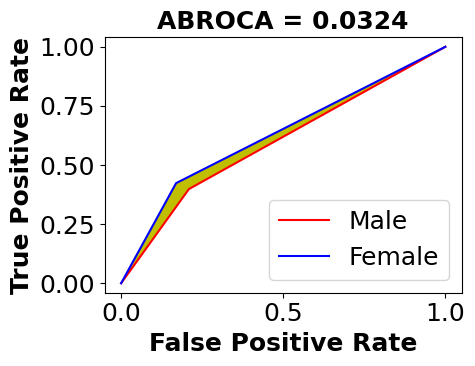

ABROCA: 0.03242894158012864


<Figure size 640x480 with 0 Axes>

In [5]:
run_eval(dataset='credit-card', algorithm='DT')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': -0.0034529790576820485}
Equal opportunity
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': 0.030875368164088424, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8650887573964497, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.23707986989519336}
Equalized odds
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': 0.031099500141115982, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8650887573964497, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.23707986989519336}
Predictive parity
{'balanced_accuracy': 0.5599344851576995, 'acc

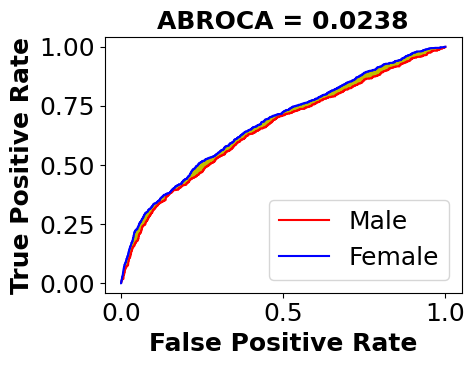

ABROCA: 0.02377930178083963


<Figure size 640x480 with 0 Axes>

In [6]:
run_eval(dataset='credit-card', algorithm='NB')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.052281802553724666}
Equal opportunity
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.0402897550879614, 'TPR_protected': 0.6520179372197309, 'TPR_non_protected': 0.6923076923076923, 'TNR_protected': 0.5717294640767611, 'TNR_non_protected': 0.52367184676545}
Equalized odds
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.08834737239927248, 'TPR_protected': 0.6520179372197309, 'TPR_non_protected': 0.6923076923076923, 'TNR_protected': 0.5717294640767611, 'TNR_non_protected': 0.52367184676545}
Predictive parity
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.578222

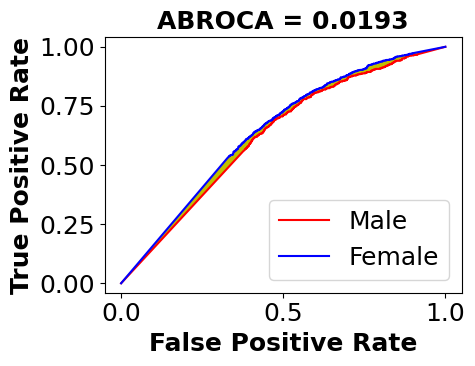

ABROCA: 0.019309398996021316


<Figure size 640x480 with 0 Axes>

In [7]:
run_eval(dataset='credit-card', algorithm='MLP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5435398307050093, 'accuracy': 0.753, 'f1-score': 0.23318385650224213, 'fairness': 0.015329377205898678}
Equal opportunity
{'balanced_accuracy': 0.5435398307050093, 'accuracy': 0.753, 'f1-score': 0.23318385650224213, 'fairness': 0.008904927428556253, 'TPR_protected': 0.16860986547085202, 'TPR_non_protected': 0.17751479289940827, 'TNR_protected': 0.9201965831968172, 'TNR_non_protected': 0.906035417419588}
Equalized odds
{'balanced_accuracy': 0.5435398307050093, 'accuracy': 0.753, 'f1-score': 0.23318385650224213, 'fairness': 0.0230660932057854, 'TPR_protected': 0.16860986547085202, 'TPR_non_protected': 0.17751479289940827, 'TNR_protected': 0.9201965831968172, 'TNR_non_protected': 0.906035417419588}
Predictive parity
{'balanced_accuracy': 0.5435398307050093, 'accuracy': 0.753, 'f1-score': 0.23318385650224213, 

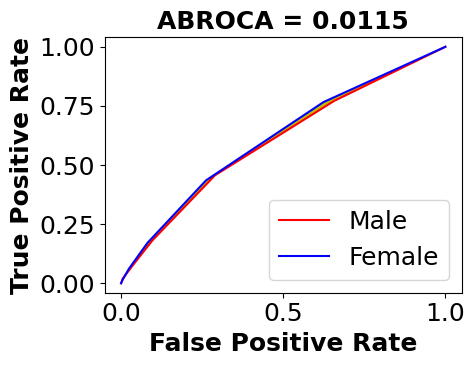

ABROCA: 0.01150308893597893


<Figure size 640x480 with 0 Axes>

In [8]:
run_eval(dataset='credit-card', algorithm='kNN')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6391972982374767, 'accuracy': 0.82, 'f1-score': 0.4355400696864111, 'fairness': 0.004525868979176076}
Equal opportunity
{'balanced_accuracy': 0.6391972982374767, 'accuracy': 0.82, 'f1-score': 0.4355400696864111, 'fairness': 0.03422400297184702, 'TPR_protected': 0.33363228699551567, 'TPR_non_protected': 0.29940828402366865, 'TNR_protected': 0.9618534987128481, 'TNR_non_protected': 0.9559089266353451}
Equalized odds
{'balanced_accuracy': 0.6391972982374767, 'accuracy': 0.82, 'f1-score': 0.4355400696864111, 'fairness': 0.04016857504935001, 'TPR_protected': 0.33363228699551567, 'TPR_non_protected': 0.29940828402366865, 'TNR_protected': 0.9618534987128481, 'TNR_non_protected': 0.9559089266353451}
Predictive parity
{'balanced_accuracy': 0.6391972982374767, 'accuracy': 0.82, 'f1-score': 0.4355400696864111, 'fairn

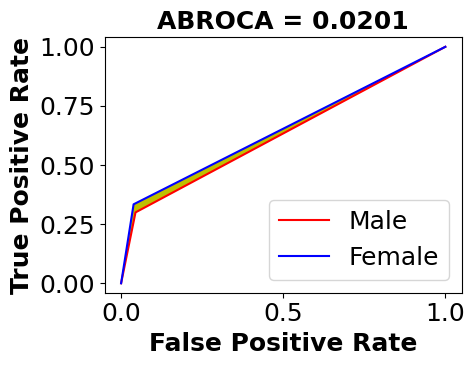

ABROCA: 0.02008428126052672


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval(dataset='credit-card', algorithm='Ada')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.4822964981447124, 'accuracy': 0.5264444444444445, 'f1-score': 0.2709544988026001, 'fairness': 0.015917000249107804}
Equal opportunity
{'balanced_accuracy': 0.4822964981447124, 'accuracy': 0.5264444444444445, 'f1-score': 0.2709544988026001, 'fairness': 0.0009340090747472218, 'TPR_protected': 0.4044843049327354, 'TPR_non_protected': 0.4035502958579882, 'TNR_protected': 0.5691551603089164, 'TNR_non_protected': 0.547162992410553}
Equalized odds
{'balanced_accuracy': 0.4822964981447124, 'accuracy': 0.5264444444444445, 'f1-score': 0.2709544988026001, 'fairness': 0.022926176973110668, 'TPR_protected': 0.4044843049327354, 'TPR_non_protected': 0.4035502958579882, 'TNR_protected': 0.5691551603089164, 'TNR_non_protected': 0.547162992410553}
Predictive parity
{'balanced_accuracy': 0.4822964981447124, 'accuracy': 0.526

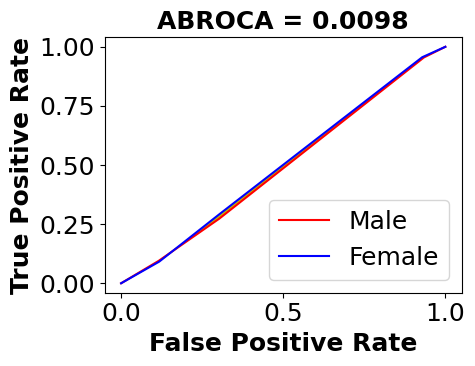

ABROCA: 0.009816293437652767


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval(dataset='credit-card', algorithm='Agar')

In [11]:
run_eval(dataset='credit-card', algorithm='DT', preprocessing_algorithm='DIR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6099518784786642, 'accuracy': 0.7186666666666667, 'f1-score': 0.3925143953934741, 'fairness': 0.02906791763165098}
Equal opportunity
{'balanced_accuracy': 0.6099518784786642, 'accuracy': 0.7186666666666667, 'f1-score': 0.3925143953934741, 'fairness': 0.0034494653328733804, 'TPR_protected': 0.4188340807174888, 'TPR_non_protected': 0.4153846153846154, 'TNR_protected': 0.8146501287151884, 'TNR_non_protected': 0.7838814600650524}
Equalized odds
{'balanced_accuracy': 0.6099518784786642, 'accuracy': 0.7186666666666667, 'f1-score': 0.3925143953934741, 'fairness': 0.034218133983009325, 'TPR_protected': 0.4188340807174888, 'TPR_non_protected': 0.4153846153846154, 'TNR_protected': 0.8146501287151884, 'TNR_non_protected': 0.7838814600650524}
Predictive parity
{'balanced_accuracy': 0.6099518784786642, 'accuracy': 0.71

In [12]:
run_eval(dataset='credit-card', algorithm='NB', preprocessing_algorithm='DIR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5673773770871985, 'accuracy': 0.41044444444444445, 'f1-score': 0.3844547563805104, 'fairness': 0.012079260667855474}
Equal opportunity
{'balanced_accuracy': 0.5673773770871985, 'accuracy': 0.41044444444444445, 'f1-score': 0.3844547563805104, 'fairness': 0.017411839626396364, 'TPR_protected': 0.852914798206278, 'TPR_non_protected': 0.8355029585798817, 'TNR_protected': 0.2955768780716124, 'TNR_non_protected': 0.27972533429707264}
Equalized odds
{'balanced_accuracy': 0.5673773770871985, 'accuracy': 0.41044444444444445, 'f1-score': 0.3844547563805104, 'fairness': 0.03326338340093615, 'TPR_protected': 0.852914798206278, 'TPR_non_protected': 0.8355029585798817, 'TNR_protected': 0.2955768780716124, 'TNR_non_protected': 0.27972533429707264}
Predictive parity
{'balanced_accuracy': 0.5673773770871985, 'accuracy': 0.

In [13]:
run_eval(dataset='credit-card', algorithm='MLP', preprocessing_algorithm='DIR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5300600069573284, 'accuracy': 0.7814444444444445, 'f1-score': 0.14441061331013486, 'fairness': 0.02448593774278759}
Equal opportunity
{'balanced_accuracy': 0.5300600069573284, 'accuracy': 0.7814444444444445, 'f1-score': 0.14441061331013486, 'fairness': 0.025865683126807648, 'TPR_protected': 0.07354260089686099, 'TPR_non_protected': 0.09940828402366864, 'TNR_protected': 0.9840861221624152, 'TNR_non_protected': 0.9620527647271413}
Equalized odds
{'balanced_accuracy': 0.5300600069573284, 'accuracy': 0.7814444444444445, 'f1-score': 0.14441061331013486, 'fairness': 0.04789904056208155, 'TPR_protected': 0.07354260089686099, 'TPR_non_protected': 0.09940828402366864, 'TNR_protected': 0.9840861221624152, 'TNR_non_protected': 0.9620527647271413}
Predictive parity
{'balanced_accuracy': 0.5300600069573284, 'accuracy':

In [14]:
run_eval(dataset='credit-card', algorithm='kNN', preprocessing_algorithm='DIR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5471185064935065, 'accuracy': 0.7511111111111111, 'f1-score': 0.2452830188679245, 'fairness': 0.005297856439929263}
Equal opportunity
{'balanced_accuracy': 0.5471185064935065, 'accuracy': 0.7511111111111111, 'f1-score': 0.2452830188679245, 'fairness': 0.010550057048849731, 'TPR_protected': 0.18116591928251122, 'TPR_non_protected': 0.19171597633136095, 'TNR_protected': 0.9087292300491459, 'TNR_non_protected': 0.9082038308637513}
Equalized odds
{'balanced_accuracy': 0.5471185064935065, 'accuracy': 0.7511111111111111, 'f1-score': 0.2452830188679245, 'fairness': 0.011075456234244246, 'TPR_protected': 0.18116591928251122, 'TPR_non_protected': 0.19171597633136095, 'TNR_protected': 0.9087292300491459, 'TNR_non_protected': 0.9082038308637513}
Predictive parity
{'balanced_accuracy': 0.5471185064935065, 'accuracy': 

In [15]:
run_eval(dataset='credit-card', algorithm='DT', preprocessing_algorithm='LFR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.4723562152133581, 'accuracy': 0.27244444444444443, 'f1-score': 0.3310175725378014, 'fairness': -0.07752431267218651}
Equal opportunity
{'balanced_accuracy': 0.4723562152133581, 'accuracy': 0.27244444444444443, 'f1-score': 0.3310175725378014, 'fairness': 0.08200175126701514, 'TPR_protected': 0.8618834080717489, 'TPR_non_protected': 0.7798816568047338, 'TNR_protected': 0.0889304937982682, 'TNR_non_protected': 0.1633538127936393}
Equalized odds
{'balanced_accuracy': 0.4723562152133581, 'accuracy': 0.27244444444444443, 'f1-score': 0.3310175725378014, 'fairness': 0.15642507026238625, 'TPR_protected': 0.8618834080717489, 'TPR_non_protected': 0.7798816568047338, 'TNR_protected': 0.0889304937982682, 'TNR_non_protected': 0.1633538127936393}
Predictive parity
{'balanced_accuracy': 0.4723562152133581, 'accuracy': 0.2

In [16]:
run_eval(dataset='credit-card', algorithm='NB', preprocessing_algorithm='LFR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.45344967532467534, 'accuracy': 0.6448888888888888, 'f1-score': 0.1229418221734358, 'fairness': 0.009320577042128825}
Equal opportunity
{'balanced_accuracy': 0.45344967532467534, 'accuracy': 0.6448888888888888, 'f1-score': 0.1229418221734358, 'fairness': 0.021694483508902282, 'TPR_protected': 0.10493273542600896, 'TPR_non_protected': 0.12662721893491125, 'TNR_protected': 0.796161947109759, 'TNR_non_protected': 0.7871340802312974}
Equalized odds
{'balanced_accuracy': 0.45344967532467534, 'accuracy': 0.6448888888888888, 'f1-score': 0.1229418221734358, 'fairness': 0.03072235038736386, 'TPR_protected': 0.10493273542600896, 'TPR_non_protected': 0.12662721893491125, 'TNR_protected': 0.796161947109759, 'TNR_non_protected': 0.7871340802312974}
Predictive parity
{'balanced_accuracy': 0.45344967532467534, 'accuracy':

In [17]:
run_eval(dataset='credit-card', algorithm='MLP', preprocessing_algorithm='LFR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.7822222222222223, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.7822222222222223, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.7822222222222223, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.7822222222222223, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.7822222222222223, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 

In [19]:
run_eval(dataset='credit-card', algorithm='kNN', preprocessing_algorithm='LFR')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5431049976808905, 'accuracy': 0.7338888888888889, 'f1-score': 0.25132854016880274, 'fairness': 0.05630267334571473}
Equal opportunity
{'balanced_accuracy': 0.5431049976808905, 'accuracy': 0.7338888888888889, 'f1-score': 0.25132854016880274, 'fairness': 0.068002228885292, 'TPR_protected': 0.1757847533632287, 'TPR_non_protected': 0.24378698224852072, 'TNR_protected': 0.9007722911303534, 'TNR_non_protected': 0.8507408745934225}
Equalized odds
{'balanced_accuracy': 0.5431049976808905, 'accuracy': 0.7338888888888889, 'f1-score': 0.25132854016880274, 'fairness': 0.11803364542222289, 'TPR_protected': 0.1757847533632287, 'TPR_non_protected': 0.24378698224852072, 'TNR_protected': 0.9007722911303534, 'TNR_non_protected': 0.8507408745934225}
Predictive parity
{'balanced_accuracy': 0.5431049976808905, 'accuracy': 0.73

In [20]:
run_eval(dataset='credit-card', algorithm='DT', postprocessing_algorithm='EOP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6131986317254174, 'accuracy': 0.7277777777777777, 'f1-score': 0.3962543124691966, 'fairness': 0.03052310166310271}
Equal opportunity
{'balanced_accuracy': 0.6131986317254174, 'accuracy': 0.7277777777777777, 'f1-score': 0.3962543124691966, 'fairness': 0.02625839148778092, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7925551138417058}
Equalized odds
{'balanced_accuracy': 0.6131986317254174, 'accuracy': 0.7277777777777777, 'f1-score': 0.3962543124691966, 'fairness': 0.06520339465988273, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7925551138417058}
Predictive parity
{'balanced_accuracy': 0.6131986317254174, 'accuracy': 0.727

In [21]:
run_eval(dataset='credit-card', algorithm='NB', postprocessing_algorithm='EOP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5547817138218925, 'accuracy': 0.37144444444444447, 'f1-score': 0.37869302580999453, 'fairness': 0.009005492703115348}
Equal opportunity
{'balanced_accuracy': 0.5547817138218925, 'accuracy': 0.37144444444444447, 'f1-score': 0.37869302580999453, 'fairness': 0.03797595988006475, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8579881656804734, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.21864835561980484}
Equalized odds
{'balanced_accuracy': 0.5547817138218925, 'accuracy': 0.37144444444444447, 'f1-score': 0.37869302580999453, 'fairness': 0.05663160613248083, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8579881656804734, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.21864835561980484}
Predictive parity
{'balanced_accuracy': 0.5547817138218925, 'accurac

In [22]:
run_eval(dataset='credit-card', algorithm='MLP', postprocessing_algorithm='EOP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6073254870129869, 'accuracy': 0.5812222222222222, 'f1-score': 0.4046754067287948, 'fairness': 0.013768137389103874}
Equal opportunity
{'balanced_accuracy': 0.6073254870129869, 'accuracy': 0.5812222222222222, 'f1-score': 0.4046754067287948, 'fairness': 0.0026375142622124814, 'TPR_protected': 0.6547085201793722, 'TPR_non_protected': 0.6520710059171597, 'TNR_protected': 0.5654107184647789, 'TNR_non_protected': 0.5543910372244308}
Equalized odds
{'balanced_accuracy': 0.6073254870129869, 'accuracy': 0.5812222222222222, 'f1-score': 0.4046754067287948, 'fairness': 0.013657195502560504, 'TPR_protected': 0.6547085201793722, 'TPR_non_protected': 0.6520710059171597, 'TNR_protected': 0.5654107184647789, 'TNR_non_protected': 0.5543910372244308}
Predictive parity
{'balanced_accuracy': 0.6073254870129869, 'accuracy': 0.5

In [23]:
run_eval(dataset='credit-card', algorithm='kNN', postprocessing_algorithm='EOP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.541614969851577, 'accuracy': 0.7534444444444445, 'f1-score': 0.2270985719261581, 'fairness': 0.006190081564298164}
Equal opportunity
{'balanced_accuracy': 0.541614969851577, 'accuracy': 0.7534444444444445, 'f1-score': 0.2270985719261581, 'fairness': 0.0052962560033963935, 'TPR_protected': 0.16860986547085202, 'TPR_non_protected': 0.16331360946745563, 'TNR_protected': 0.9194945003510414, 'TNR_non_protected': 0.912902059992772}
Equalized odds
{'balanced_accuracy': 0.541614969851577, 'accuracy': 0.7534444444444445, 'f1-score': 0.2270985719261581, 'fairness': 0.01188869636166584, 'TPR_protected': 0.16860986547085202, 'TPR_non_protected': 0.16331360946745563, 'TNR_protected': 0.9194945003510414, 'TNR_non_protected': 0.912902059992772}
Predictive parity
{'balanced_accuracy': 0.541614969851577, 'accuracy': 0.7534

In [24]:
run_eval(dataset='credit-card', algorithm='DT', postprocessing_algorithm='CEP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.03079995659112042}
Equal opportunity
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.02625839148778092, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7921937116010119}
Equalized odds
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.7276666666666667, 'f1-score': 0.3961566888396157, 'fairness': 0.06556479690057665, 'TPR_protected': 0.42152466367713004, 'TPR_non_protected': 0.3952662721893491, 'TNR_protected': 0.8315001170138077, 'TNR_non_protected': 0.7921937116010119}
Predictive parity
{'balanced_accuracy': 0.6131276089981447, 'accuracy': 0.727

In [25]:
run_eval(dataset='credit-card', algorithm='NB', postprocessing_algorithm='CEP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': -0.0034529790576820485}
Equal opportunity
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': 0.030875368164088424, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8650887573964497, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.23707986989519336}
Equalized odds
{'balanced_accuracy': 0.5599344851576995, 'accuracy': 0.37777777777777777, 'f1-score': 0.38189845474613693, 'fairness': 0.031099500141115982, 'TPR_protected': 0.8959641255605382, 'TPR_non_protected': 0.8650887573964497, 'TNR_protected': 0.23730400187222092, 'TNR_non_protected': 0.23707986989519336}
Predictive parity
{'balanced_accuracy': 0.5599344851576995, 'acc

In [26]:
run_eval(dataset='credit-card', algorithm='MLP', postprocessing_algorithm='CEP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.052281802553724666}
Equal opportunity
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.0402897550879614, 'TPR_protected': 0.6520179372197309, 'TPR_non_protected': 0.6923076923076923, 'TNR_protected': 0.5717294640767611, 'TNR_non_protected': 0.52367184676545}
Equalized odds
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.5782222222222222, 'f1-score': 0.40872274143302184, 'fairness': 0.08834737239927248, 'TPR_protected': 0.6520179372197309, 'TPR_non_protected': 0.6923076923076923, 'TNR_protected': 0.5717294640767611, 'TNR_non_protected': 0.52367184676545}
Predictive parity
{'balanced_accuracy': 0.6111143320964749, 'accuracy': 0.578222

In [27]:
run_eval(dataset='credit-card', algorithm='kNN', postprocessing_algorithm='CEP')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.540742404916512, 'accuracy': 0.7561111111111111, 'f1-score': 0.22135509045760907, 'fairness': 0.030177187153931348}
Equal opportunity
{'balanced_accuracy': 0.540742404916512, 'accuracy': 0.7561111111111111, 'f1-score': 0.22135509045760907, 'fairness': 0.032223313078780486, 'TPR_protected': 0.1452914798206278, 'TPR_non_protected': 0.17751479289940827, 'TNR_protected': 0.9328340744207817, 'TNR_non_protected': 0.906035417419588}
Equalized odds
{'balanced_accuracy': 0.540742404916512, 'accuracy': 0.7561111111111111, 'f1-score': 0.22135509045760907, 'fairness': 0.059021970079974145, 'TPR_protected': 0.1452914798206278, 'TPR_non_protected': 0.17751479289940827, 'TNR_protected': 0.9328340744207817, 'TNR_non_protected': 0.906035417419588}
Predictive parity
{'balanced_accuracy': 0.540742404916512, 'accuracy': 0.756